Sampling frequency: 9999.90 Hz
Cross-correlation delay: -120.30 ms
FFT phase delay: -147.01 ms
Heart Rate: 78.00 BPM


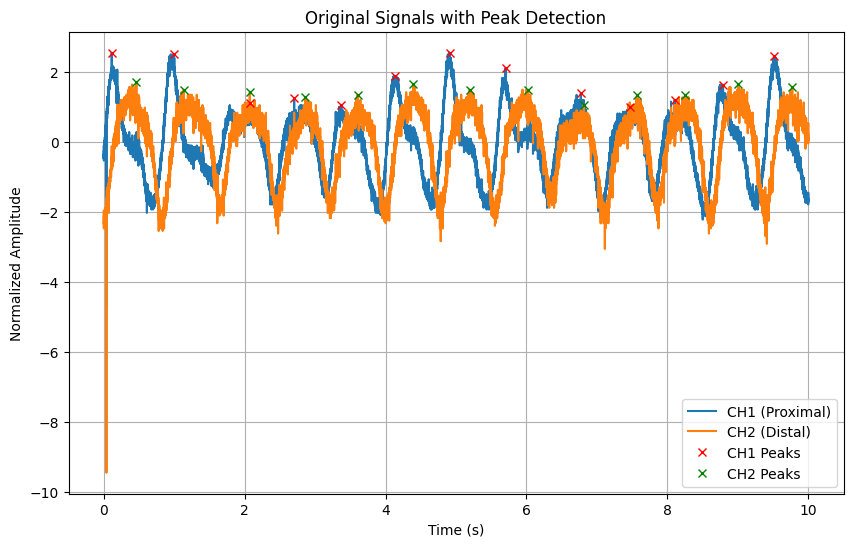

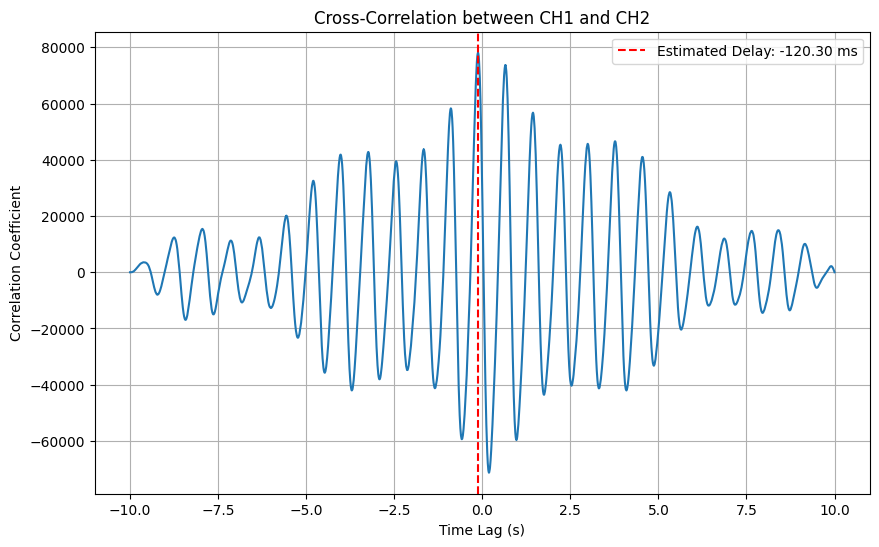

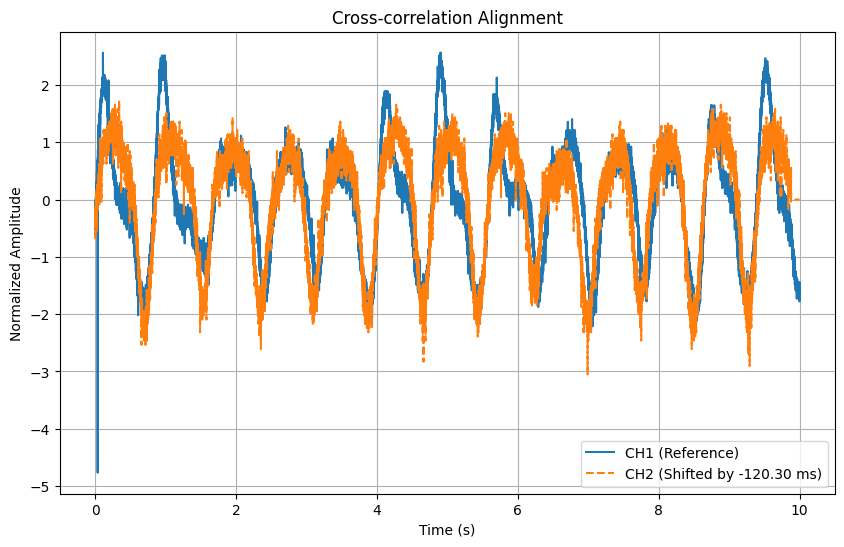

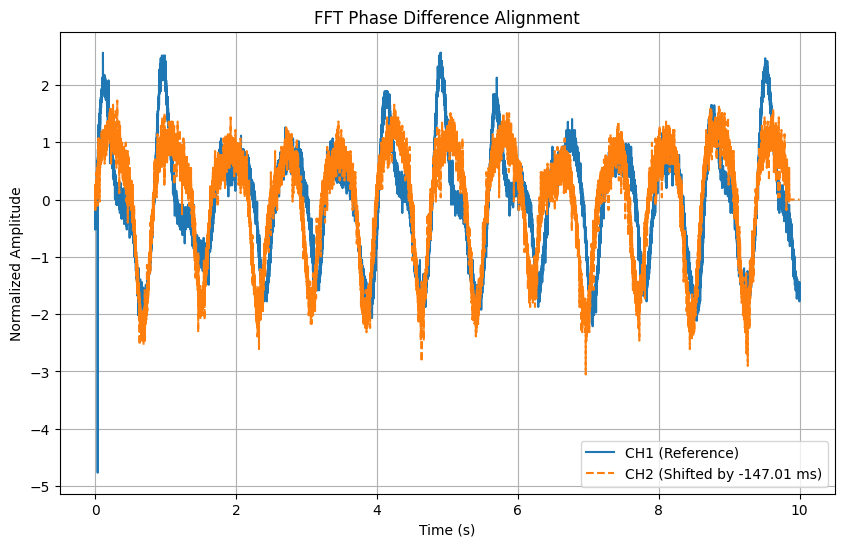

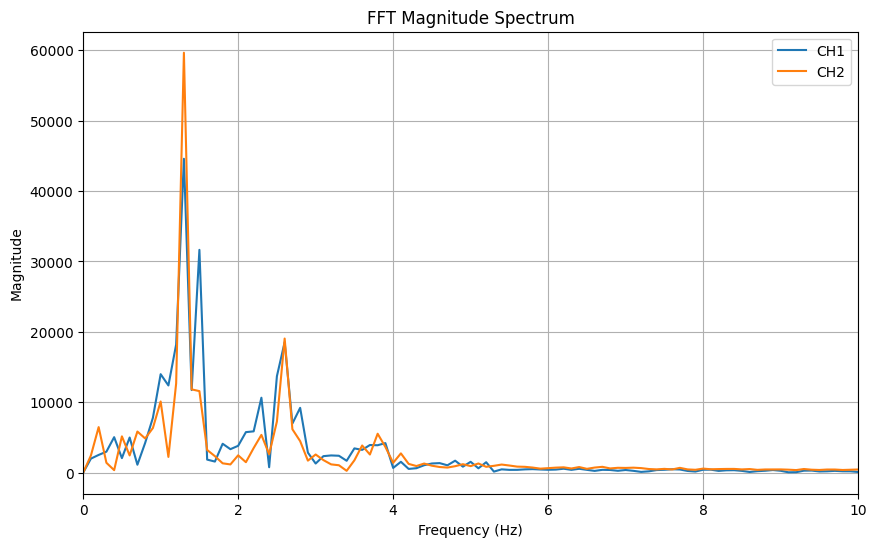

Time Delay: 120.30 ms
Systolic: 134 mmHg
Diastolic: 76 mmHg
Heart Rate: 78 BPM


In [2]:
# from vds1022 import * # For use with the VDS1022 device
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
    
def analyze_time_delays(df, sample_duration=10):
    """
    Analyze time delays using both cross-correlation and FFT methods,
    with visualization including correlation and FFT magnitude plots
    """
    # Extract time and signals
    time = df['Time'].values
    ch1_signal = df['CH1'].values
    ch2_signal = df['CH2'].values
    
    # Calculate sampling frequency
    sampling_freq = 1 / np.mean(np.diff(time))
    print(f"Sampling frequency: {sampling_freq:.2f} Hz")

    # Select sample duration
    sample_points = int(sample_duration * sampling_freq)
    ch1_sample = ch1_signal[:sample_points]
    ch2_sample = ch2_signal[:sample_points]
    time_sample = time[:sample_points]

    # Normalize signals
    ch1_norm = (ch1_sample - np.mean(ch1_sample)) / np.std(ch1_sample)
    ch2_norm = (ch2_sample - np.mean(ch2_sample)) / np.std(ch2_sample)

    # Method 1: Cross-correlation
    correlation = signal.correlate(ch1_norm, ch2_norm, mode='full', method='fft')
    lags = signal.correlation_lags(len(ch1_norm), len(ch2_norm), mode='full')
    max_corr_index = np.argmax(correlation)
    corr_delay = lags[max_corr_index] / sampling_freq

    # Method 2: FFT Phase Difference
    def perform_fft(signal):
        n = len(signal)
        fft_result = fft(signal)
        freqs = fftfreq(n, 1/sampling_freq)
        return freqs[:n//2], fft_result[:n//2]

    freqs_ch1, fft_ch1 = perform_fft(ch1_norm)
    freqs_ch2, fft_ch2 = perform_fft(ch2_norm)

    # Calculate phase difference
    phase_diff = np.angle(fft_ch2) - np.angle(fft_ch1)
    
    # Find the dominant frequency (excluding very low frequencies)
    start_freq = 0.5  # Hz
    start_index = np.argmin(np.abs(freqs_ch1 - start_freq))
    dominant_freq_index = start_index + np.argmax(np.abs(fft_ch1[start_index:]))
    dominant_freq = freqs_ch1[dominant_freq_index]
    
    fft_delay = phase_diff[dominant_freq_index] / (2 * np.pi * dominant_freq)

    # Find peaks for visualization
    ch1_peaks, _ = find_peaks(ch1_norm, height=0.5, distance=int(sampling_freq*0.5))
    ch2_peaks, _ = find_peaks(ch2_norm, height=0.5, distance=int(sampling_freq*0.5))

    print(f"Cross-correlation delay: {corr_delay*1000:.2f} ms")
    print(f"FFT phase delay: {fft_delay*1000:.2f} ms")
    hr_ch1 = (len(ch1_peaks) / sample_duration) * 60
    hr_ch2 = (len(ch2_peaks) / sample_duration) * 60
    avg_heart_rate = (hr_ch1 + hr_ch2) / 2
    print(f"Heart Rate: {avg_heart_rate:.2f} BPM")
    
    # Figure 1: Original signals with detected peaks
    plt.figure(figsize=(10, 6))
    plt.plot(time_sample, ch1_norm, label='CH1 (Proximal)')
    plt.plot(time_sample, ch2_norm, label='CH2 (Distal)')
    plt.plot(time_sample[ch1_peaks], ch1_norm[ch1_peaks], "rx", label='CH1 Peaks')
    plt.plot(time_sample[ch2_peaks], ch2_norm[ch2_peaks], "gx", label='CH2 Peaks')
    plt.title('Original Signals with Peak Detection')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Figure 2: Cross-correlation
    plt.figure(figsize=(10, 6))
    plt.plot(lags / sampling_freq, correlation)
    plt.title('Cross-Correlation between CH1 and CH2')
    plt.xlabel('Time Lag (s)')
    plt.ylabel('Correlation Coefficient')
    plt.axvline(x=corr_delay, color='r', linestyle='--', 
                label=f'Estimated Delay: {corr_delay*1000:.2f} ms')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 3: Signals aligned using cross-correlation
    shift_samples_corr = int(corr_delay * sampling_freq)
    ch2_shifted_corr = np.zeros_like(ch2_norm)
    if shift_samples_corr < 0:
        ch2_shifted_corr[:shift_samples_corr] = ch2_norm[-shift_samples_corr:]
    else:
        ch2_shifted_corr[shift_samples_corr:] = ch2_norm[:-shift_samples_corr]
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_sample, ch1_norm, label='CH1 (Reference)')
    plt.plot(time_sample, ch2_shifted_corr, '--', 
             label=f'CH2 (Shifted by {corr_delay*1000:.2f} ms)')
    plt.title('Cross-correlation Alignment')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 4: Signals aligned using FFT phase difference
    shift_samples_fft = int(fft_delay * sampling_freq)
    ch2_shifted_fft = np.zeros_like(ch2_norm)
    if shift_samples_fft < 0:
        ch2_shifted_fft[:shift_samples_fft] = ch2_norm[-shift_samples_fft:]
    else:
        ch2_shifted_fft[shift_samples_fft:] = ch2_norm[:-shift_samples_fft]
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_sample, ch1_norm, label='CH1 (Reference)')
    plt.plot(time_sample, ch2_shifted_fft, '--', 
             label=f'CH2 (Shifted by {fft_delay*1000:.2f} ms)')
    plt.title('FFT Phase Difference Alignment')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Figure 5: FFT magnitude
    plt.figure(figsize=(10, 6))
    plt.plot(freqs_ch1, np.abs(fft_ch1), label='CH1')
    plt.plot(freqs_ch2, np.abs(fft_ch2), label='CH2')
    plt.title('FFT Magnitude Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid()
    plt.xlim(0, 10)  # Limit x-axis to 10 Hz for better visualization
    plt.show()

    return corr_delay, fft_delay, avg_heart_rate

# For use of CSV files
file_path = 'output_with_time129_72_77.csv' # 'output_with_timesys_dias_HR.csv'
df = pd.read_csv(file_path)

# For use with the VDS1022 device uncomment the following lines
# dev = VDS1022(debug=0)
# dev.set_sampling('10k')  
# dev.set_channel(CH1, range='500mv', offset=0.5, probe='x10', coupling='AC')
# dev.set_channel(CH2, range='500mv', offset=0.5, probe='x10', coupling='AC')

# frames = dev.read('10s')
# frames.plot()

# # Convert frames to DataFrame
# df = frames.to_dataframe()

# # Add time column
# df['Time'] = frames.x()

# # Reorder columns to have 'Time' as the first column
# df = df[['Time', 'CH1', 'CH2']]

# Use the algorithm
time_delay_corr, time_delay_fft, avg_heart_rate = analyze_time_delays(df)

# Calculate blood pressure from time delay (relation obtained from calibration)
time_delay = abs(time_delay_corr * 1000)
a = -0.3167
b = 173.08
c = -0.0738
d = 85.4437
systolic = time_delay * a + b
diastolic = time_delay * c + d

# Print results
print(f"Time Delay: {time_delay:.2f} ms")
print(f"Systolic: {int(systolic)} mmHg")
print(f"Diastolic: {int(diastolic)} mmHg")
print(f"Heart Rate: {int(avg_heart_rate)} BPM")